# Foundations of Data Mining: Assignment 2

Please complete all assignments in this notebook. You should submit this notebook, as well as a PDF version (See File > Download as).

In [1]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100 # This controls the size of your figures
# Comment out and restart notebook if you only want the last output of each cell.
InteractiveShell.ast_node_interactivity = "none" 

In [2]:
# This is a temporary read-only OpenML key. Replace with your own key later. 
oml.config.apikey = '11e82c8d91c5abece86f424369c71590'

## Kernel selection (4 points (1+2+1))
SVMs can be trained with different kernels. Generate a 2-dimensional dataset as shown below and study the effect of the choice of kernel by visualizing the results.

- Train a SVM classifier on the dataset using respectively a linear, polynomial and radial basis function (RBF) kernel, evaluate the performance of each kernel using 10-fold cross-validation and AUC. Which one works best? Visualize the results. Can you intuitively explain why one kernel is more suited than another?
    - Hint: you can use the visualization code used in class. It is under mglearn/plot_svm.py > plot_svm_kernels().
- Take the RBF kernel and vary both the C parameter and the kernel width ($\gamma$). Use 3 values for each (a very small, default, and very large value). For each of the 9 combinations, create the same RBF plot as before, report the number of support vectors, and the AUC performance. Explain the performance results. When are you over/underfitting?
    - Hint: values for C and $\gamma$ are typically in [$2^{-15}..2^{15}$] on a log scale. 
    - Hint: don't count the support vectors manually, retrieve them from the trained SVM.
- Vary C and $\gamma$ again, but this time use a grid of at least 20x20, vary both parameters uniformly on a log scale, and visualise the results using a $C \times \gamma \rightarrow AUC$ heatmap. Explain the performance results, and compare them to the 9 results obtained in the previous subquestion. Can you also tell in which regions of the heatmap you are over/underfitting?
    - Hint: We've constructed such a heatmap in class and in assignment 1.

In [24]:
X, y = make_blobs(centers=2, n_samples=1000, random_state=0)

NameError: name 'make_blobs' is not defined

## Robots and SVMs (4 points (2+1+1))

The [Wall Robot Navigation dataset](http://www.openml.org/d/1497) contains about 5500 readings of an ultrasound sensor array mounted on a robot, and your task is to finetune and train an SVM classifier to predict how the robot should move next.

- Make a stratified 80-20 split of the data. On the training set alone, optimize the main hyperparameters of the SVM for Accuracy with a random search. Vary at least the main kernel types (linear, polynomial, and RBF), the C parameter, the $\gamma$ parameter for the RBF kernel and the exponent/degree for the polynomial kernel. Report the optimal hyperparameter settings and Accuracy performance. 
    - The degree of the polynonial is typically in the range 2..10.
    - Hint: note that the hyperparameter ranges depend on each other. For instance, $\gamma$ only makes sense if you have selected the RBF kernel as well. We've seen in class how to define multiple hyperparameter spaces in a random/grid search.
- Use a 5x3-fold (5 outer, 3 inner) nested cross-validation (CV) on the **whole** dataset to obtain a clean evaluation. What is the mean optimized performance? Is this in line with the optimized result of the random search of the previous question?
- Train an SVM using the optimal hyperparameter configuration you found (in part 1 of this question) and test it on the held out (20%) test set. Compare this Accuracy result with the (mean) result of the nested CV. If you would build this robot in practice, how would you find the hyperparameters to use, and which performance would you expect? Is it truly necessary to tune the hyperparameters? Which hyperparameters were most important to tune?

In [3]:
robot_data = oml.datasets.get_dataset(1497) # Download Robot data
# Get the predictors X and the labels y
X, y = robot_data.get_data(target=robot_data.default_target_attribute)

(5456, 24)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import cross_val_score
from scipy.stats import expon
from sklearn import svm


In [31]:
def extract_value(info, key):
    if key in info:
        return info[key]
    return 'Na'


def create_dataframe(results):
    items = []
    for result in results:
        info = []
        info.append(result[0]['C'])
        info.append(extract_value(result[0], 'gamma'))
        info.append(extract_value(result[0], 'coef0'))
        info.append(extract_value(result[0], 'degree'))
        info.append(result[1])
        items.append((result[0]['kernel'], info))
        
    return pd.DataFrame.from_items(items, orient='index', 
                                   columns=['C', 'r', 'gamma', 'degree', 'accuracy'])

def select_best(results):
    best_accuracy = 0.0
    best_params = None
    
    for result in results:
        if result[1] > best_accuracy:
            best_accuracy = result[1]
            best_params = result[0]
    
    return (best_params, best_accuracy)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,
                                                    random_state=0,stratify=y)

param_grid = [
    {'kernel': ['linear'], 
     'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
    {'kernel': ['poly'],
     'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'degree': np.arange(2,11).tolist(),
     'coef0': [1.0/16, 1.0/8, 1.0/4, 1.0/2, 1.0, 2, 4, 8, 16, 32]},
    {'kernel': ['rbf'], 
     'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
     'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
    {'kernel': ['sigmoid'],
     'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
     'coef0': [1.0/16, 1.0/8, 1.0/4, 1.0/2, 1.0, 2, 4, 8, 16, 32]}
 ]

n_iter_search = 6
random_search_results = []
clf_performances = []

for params in param_grid:
    random_search = RandomizedSearchCV(svm.SVC(),
                                       param_distributions=params,
                                       n_iter=n_iter_search,
                                       scoring='accuracy',
                                       cv=5)
    random_search.fit(X_train, y_train)
    
    clf_performances.append((random_search.best_params_,
                           random_search.best_score_))
    
    random_search_results.append(
        {
            random_search.best_params_['kernel'] :
            random_search.cv_results_
        }
    )
    

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=6, n_jobs=1,
          param_distributions={'kernel': ['linear'], 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='accuracy', verbose=0)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=6, n_jobs=1,
          param_distributions={'degree': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'kernel': ['poly'], 'coef0': [0.0625, 0.125, 0.25, 0.5, 1.0, 2, 4, 8, 16, 32], 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='accuracy', verbose=0)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=6, n_jobs=1,
          param_distributions={'kernel': ['rbf'], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='accuracy', verbose=0)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params={}, iid=True, n_iter=6, n_jobs=1,
          param_distributions={'kernel': ['sigmoid'], 'coef0': [0.0625, 0.125, 0.25, 0.5, 1.0, 2, 4, 8, 16, 32], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='accuracy', verbose=0)

,C,r,gamma,degree,accuracy
linear,10.0,Na,Na,Na,0.73
poly,0.1,Na,0.062,5,0.90
rbf,10.0,0.1,Na,Na,0.90
sigmoid,100.0,0.0001,2,Na,0.57


Parameters of the best svm classifier: {'degree': 5, 'kernel': 'poly', 'coef0': 0.0625, 'C': 0.1}
Best accuracy score on random search cv: 0.90


### Optimal hyperparameters settings and accuracy performance

In [1]:
svm_best_parameters, best_accuracy = select_best(clf_performances)
df = create_dataframe(clf_performances)
display(df)
print("Optimal hyperparameters: {}".format(svm_best_parameters))
print("Accuracy performance: {:.2f}".format(best_accuracy))

NameError: name 'svm_best_parameters' is not defined

In [33]:

def construct_grid_params(best_parameters):
    variable_param = []
    grid_params = []
    if best_parameters['kernel'] == 'poly':
        grid_params.append({
                'kernel': ['poly'],
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'degree': [best_parameters['degree']],#*8,
                'coef0': [best_parameters['coef0']],#*8
            })
        variable_param.append('param_C')
        
        grid_params.append({
                'kernel': ['poly'],
                'C': [best_parameters['C']],#*9,
                'degree': np.arange(2,11).tolist(),
                'coef0': [best_parameters['coef0']],#*9                
            })
        variable_param.append('param_degree')
        
        grid_params.append({
                'kernel': ['poly'],
                'C': [best_parameters['C']],#*10,
                'degree': [best_parameters['degree']],#*10,
                'coef0': [1.0/16, 1.0/8, 1.0/4, 1.0/2, 1.0, 2, 4, 8, 16, 32]                                
            })
        variable_param.append('param_coef0') 
    
    elif best_parameters['kernel'] == 'rbf':
        grid_params.append({
                'kernel': ['rbf'],
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'gamma': [best_parameters['gamma']],#*8
            })
        variable_param.append('param_C')
        
        grid_params.append({
                'kernel': ['rbf'],
                'C': [best_parameters['C']],#*8,
                'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]                
            })
        variable_param.append('param_gamma')
    
    elif best_parameters['kernel'] == 'sigmoid':
        grid_params.append({
                'kernel': ['sigmoid'],
                'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'gamma': [best_parameters['gamma']],#*8,
                'coef0': [best_parameters['coef0']],#*8
            })
        variable_param.append('param_C')
        
        grid_params.append({
                'kernel': ['sigmoid'],
                'C': [best_parameters['C']],#*8,
                'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'coef0': [best_parameters['coef0']],#*8                
            })
        variable_param.append('param_gamma')
        
        grid_params.append({
                'kernel': ['sigmoid'],
                'C': [best_parameters['C']],#*10,
                'gamma': [best_parameters['gamma']],#*10,
                'coef0': [1.0/16, 1.0/8, 1.0/4, 1.0/2, 1.0, 2, 4, 8, 16, 32]                                
            })
        variable_param.append('param_coef0')
    
    return (grid_params, variable_param)

def extract_variable(parameters):
    variable = []
    for key in parameters:
        if len(parameters[key]) > 1:
            variable = parameters[key]
    return variable


In [34]:
ev_grid_params, variable_param = construct_grid_params(svm_best_parameters)
cv_results = []

for index, grid_param in enumerate(ev_grid_params):
    
    grid_search = GridSearchCV(svm.SVC(), grid_param, scoring='accuracy', cv=5)
    grid_search.fit(X_train, y_train)
    
    cv_results.append({variable_param[index]:{'mean_test_score':
                                              grid_search.cv_results_["mean_test_score"],
                                              'variable_values':
                                              extract_variable(grid_param)
                                             }})

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'degree': [5], 'kernel': ['poly'], 'coef0': [0.0625], 'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'degree': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'kernel': ['poly'], 'coef0': [0.0625], 'C': [0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'degree': [5], 'kernel': ['poly'], 'coef0': [0.0625, 0.125, 0.25, 0.5, 1.0, 2, 4, 8, 16, 32], 'C': [0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

### Visualizing hyperparameter impact

In [35]:
def create_plot(parameters, fig):
    var_name = list(parameters.keys())[0]
    content = parameters[var_name]
    var_value = content['variable_values']
    mean_test_scores = content['mean_test_score']
    if (var_name == 'param_C' or var_name == 'param_gamma'):
        plt.semilogx(var_value, mean_test_scores)
    else:
        plt.plot(var_value, mean_test_scores)
    plt.legend(["variable: " + var_name], loc="upper left")
    plt.figure(fig)
    plt.show()
    

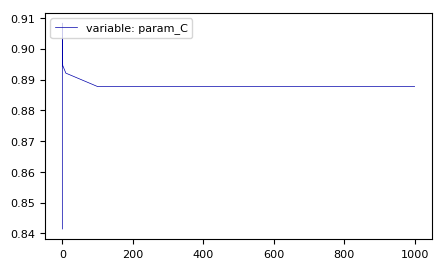

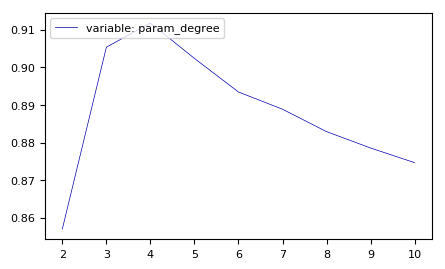

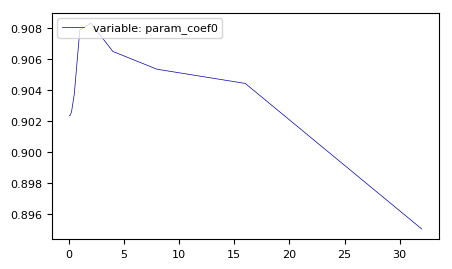

In [36]:
labels = []
for index, element in enumerate(cv_results):
  create_plot(element, index)

Make a stratified 80-20 split of the data. On the training set alone, optimize the main hyperparameters of the SVM for Accuracy with a random search. Vary at least the main kernel types (linear, polynomial, and RBF), the C parameter, the  γ  parameter for the RBF kernel and the exponent/degree for the polynomial kernel. Report the optimal hyperparameter settings and Accuracy performance.
    The degree of the polynonial is typically in the range 2..10.
    Hint: note that the hyperparameter ranges depend on each other. For instance,  γγ only makes sense if you have selected the RBF kernel as well. We've seen in class how to define multiple hyperparameter spaces in a random/grid search.

In [38]:
results = []

for params in param_grid:
    scores= cross_val_score(RandomizedSearchCV(svm.SVC(), 
                                               param_distributions=params,
                                               n_iter=n_iter_search,
                                               scoring='accuracy',
                                               cv=3),
                                           X, y, cv=5)
    
    results.append((params['kernel'], scores.mean()))

best_kernel, best_mean_accuracy = select_best(results)


Mean accuracy for nested cross-validation: 0.86


In [ ]:
print("Mean accuracy for nested cross-validation: {:.2f}".format(best_mean_accuracy))

The accuracy obtained from the random search is better than the mean optimized performance obtained with cross validation. Random search seems to perform better than cross validation, but the difference between performance values is small, and cross validation works over different training/test sets while random search does not (this time it seems like it got a nice training/test split).We think the results from cross validation and random search are in line.

In [39]:
opt_svm = svm.SVC(**svm_best_parameters)
opt_svm.fit(X_train, y_train)
score = opt_svm.score(X_test, y_test)
print("Computed score on test set: {:.2f}".format(score))

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0625,
  decision_function_shape=None, degree=5, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Computed score on test set: 0.92


The accuracy result of the held out test set is better than the results from cross validation.

In practice we could use nested cross validation implemented from scratch to retrieve the best hyperparameters trained using grid search or random search.

I would expect a performance better than 0.90

The graphs from before show that parameter C affects the svm's peformance more than the other parameters.

## A benchmark study (3 points (2+1))

A benchmark study is an experiment in which multiple algorithms are evaluated on multiple datasets. The end goal is to study whether one algorithm is generally better than the others. Meaningful benchmark studies can grow quite complex, here we do a simplified variant.

* Download OpenML datasets 37, 470, 1120, 1464 and 1471. They are sufficiently large (e.g., at least 500 data points) so that the performance estimation is trustworthy. Select at least three classifiers that we discussed in class, e.g. kNN, Logistic Regression, Random Forests, Gradient Boosting, SVMs, Naive Bayes. Note that some of these algorithms take longer to train. Evaluate all classifiers (with default parameter settings) on all datasets, using a 10-fold CV and AUC. Show the results in a table and interpret them. Which is the best algorithm in this benchmark?
    * Note that these datasets have categorical features, different scales, missing values, and (likely) irrelevant features. You'll need to build pipelines to correctly build all models. Also remove any row identifiers (see, e.g., https://www.openml.org/d/1120)
    * Hint: You can either compare the performances directly, or (better) use a statistical significance test, e.g. a pairwise t-test or (better) Wilcoxon signed ranks test, to see whether the performance differences are significant. This is covered in statistics courses. You can then count wins, ties and losses.
* Repeat the benchmark, but now additionally optimize the main hyperparameters of each algorithm in a grid or random search (explore at least 5 values per hyperparameter, where possible). Does this affect the ranking of the algorithms?

## Gaussian Processes (2 points (1+1))

Consider the RAM prices dataset (included in the data folder). Separate the data in a training set of all data points up until the year 2000, and a test set with all points after that.

- Train several of the algorithms we have covered in the course that can handle regression. Include at least linear regression, decision tree, and RandomForest. Which ones give the best $R^2$ performance on the test set? Plot the predictions (both on the training and test data) on the figure below. Use different colors for different algorithms or build multiple plots.
- Train a Gaussian process on an increasing amount of samples of the training data. Start with 5 random sample and plot the predictions (both the mean and the uncertainty interval) for both training and test data, as shown in class. Now add 5 more points and retrain and redraw. Do this a couple of times and interpret/explain what you see. Finally, train the Gaussian on the full dataset and again show plot the predictions. Evaluate on the test set using  $R^2$. Compare these results with those achieved with other algorithms and explain.

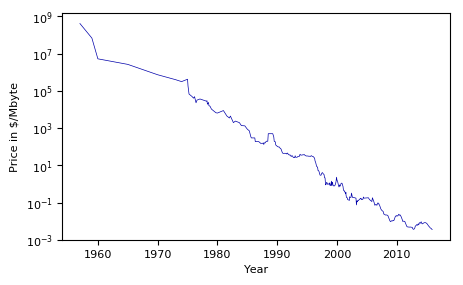

In [3]:
ram_prices = pd.read_csv('data/ram_price.csv')

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte");

## A mini-data mining challenge (2 points (+1))

The goal here is to use everything you have learned to build the best model for a given classification task. The task is hosted on OpenML, so you will receive the train-test splits, and your model will be evaluated on the server. The goal is to reasonably select algorithms and hyperparameter settings to obtain the best model. You can also do model selection and parameter optimization as you have done before. Skeleton code is provided in the OpenML tutorial.

- All details can be found online:
    - The OpenML Task ID is 145677: https://www.openml.org/t/145677
    - The dataset description can be found here: https://www.openml.org/d/4134
- A leaderboard is kept of the best models: https://www.openml.org/t/145677#!people
    - You are able to see the solutions of others (by clicking in the timeline or run list), but resubmission of the exact same solution does not register on the leaderboard.
    - You can share one account (one API key) per team. In case you use two, we take the one that performs best.
- You can document the different experiments that you ran in this notebook. For each experiment, provide a description of how you chose the algorithms and parameters that you submitted. Try to reason about which experiments to try, don't just do an immense random search.
- Points are rewarded as follows:
    - 1 point for the breadth of experiments you ran (algorithms, hyperparameter settings)
    - 1 point for reasoning/insight and interpretation of the results
    - 1 (bonus) point for every team who has uploaded the best solution thus far **on AUC** (who reaches the top of the leaderboard at any moment during the assignment)
        - Note: On the leaderboard page, the 'frontier' line is drawn, and your top ranking is also shown in the table.
        
Note: Report AUC scores in your report as well. In case of issues with OpenML we will use the experiments and scores mentioned your report.